# AutoEncoder in TensorFlow 2.0

### 출처 : https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7

# Colab Tensorflow 2.0 시작하기

In [1]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속도 TPU변경
%tensorflow_version 2.x
#런타임 -> 런타임 다시시작

TensorFlow 2.x selected.


In [3]:
# tensorlow version 확인
import tensorflow
print(tensorflow.__version__)

2.0.0


# 1. 서브패키지 Import

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

# 2. MNIST 데이터 불러오기

In [7]:
# mnist 데이터 불러오기
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# 이미지셋 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
# 하이퍼파라미터 설정
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞어줌
train_ds = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test)).batch(BATCH_SIZE)

In [10]:
# 데이터 shape 확인
x_train.shape, x_test.shape 

((60000, 784), (10000, 784))

# 3. AutoEncoder Modeling

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def AE():

    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(28*28,)))  # 입력계층
    model.add(layers.Activation('relu'))      

    model.add(layers.Dense(128))                        # 은닉계층
    model.add(layers.Activation('relu'))

    ## Decoder 구간
    model.add(layers.Dense(256))                        # 은닉계층
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(28*28))                      # 출력계층
    model.add(layers.Activation('sigmoid'))

    return model

In [0]:
# model 함수 실행
model = AE()

# 4. Loss, optimizer 설정


In [0]:
loss_object = tf.keras.losses.MeanSquaredError()  # Loss는 MSE
optimizer = tf.keras.optimizers.Adam()            # optimizer는 adam

# 변수 설정
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')

# 5. 모델 학습

In [0]:
# `tf.function` 이 데코레이터는 함수를 "컴파일" 한다.
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    predictions = model(images)                 # AE 모델에 image 학습
    loss = loss_object(images, predictions)     # loss값 구함

  # tape에 기록하며 미분이 실행됨
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(images, predictions)

@tf.function
def test_step(images):
  predictions = model(images)                   # AE 모델에 image 학습
  t_loss = loss_object(images, predictions)     # loss값 구함
  
  test_loss(t_loss)
  test_accuracy(images, predictions)

In [0]:
# train 함수 정의 (텐서플로우 2.0에서는 직접 함수를 만들어야함)
def train(train_ds, test_ds, epochs):
  for epoch in range(epochs):      # 매 epoch 마다 학습이 진행된다
    for images in train_ds:
      train_step(images)           # train 이미지 학습

    for test_images in test_ds:
      test_step(test_images)       # test 이미지 학습 (validation으로 사용됨)

    # print 보여주기 설정
    template = 'epoch: {}, loss: {}, acc: {}, val_loss: {}, val_acc: {}'
    print (template.format(epoch+1,       
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))

In [22]:
# train 함수 실행, trian data, val data, epoch 순으로 작성
train(train_ds, test_ds, 5) 

epoch: 1, loss: 0.020802021026611328, acc: 28.37020492553711, val_loss: 0.015082525089383125, val_acc: 30.577049255371094
epoch: 2, loss: 0.019104819744825363, acc: 27.779844284057617, val_loss: 0.014138739556074142, val_acc: 29.568321228027344
epoch: 3, loss: 0.017726143822073936, acc: 27.206867218017578, val_loss: 0.013306441716849804, val_acc: 28.947099685668945
epoch: 4, loss: 0.016592741012573242, acc: 26.65804100036621, val_loss: 0.012594780884683132, val_acc: 28.26712417602539
epoch: 5, loss: 0.01563206873834133, acc: 26.131752014160156, val_loss: 0.011994976550340652, val_acc: 27.673828125


# 5. Visualization

In [0]:
import matplotlib.pyplot as plt
import numpy as np

sample_size = 10                        # 보여줄 sample 갯수 설정
prediction = model.predict(x_test)      # test 데이터로 예측하기(predict 함수 사용)

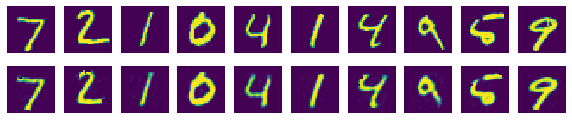

In [26]:
# plot 하기
fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))
for i in range(sample_size):
  org_img = x_test[i].reshape(28,28)
  rec_img = prediction[i].reshape(28,28)
  
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  
  ax[0][i].imshow(org_img)
  ax[1][i].imshow(rec_img)

plt.show()